# Tutorial 1: Generative Adversarial Networks (GANs) for clothes figure generation

# **1. GAN first introduction**


A Generative Adversarial Network, or GAN, is a type of machine learning framework designed to generate new data similar to the training set it’s given. Introduced by Ian Goodfellow and his team in 2014, GANs are like a creative duo: two neural networks working together (and against each other) to produce realistic outputs, such as images, music, or even text. Think of it as an artist and a critic locked in a friendly competition.
GANs consist of two main components:

**Generator**: This network takes random noise (like a bunch of scrambled numbers) as input and tries to create something meaningful—like a fake image of a cat. Its goal is to "fool" the other network.

**Discriminator**: This network acts as the judge. It looks at data—both real examples (actual cat photos) and fake ones from the Generator—and tries to tell them apart. Its job is to get better at spotting the fakes.

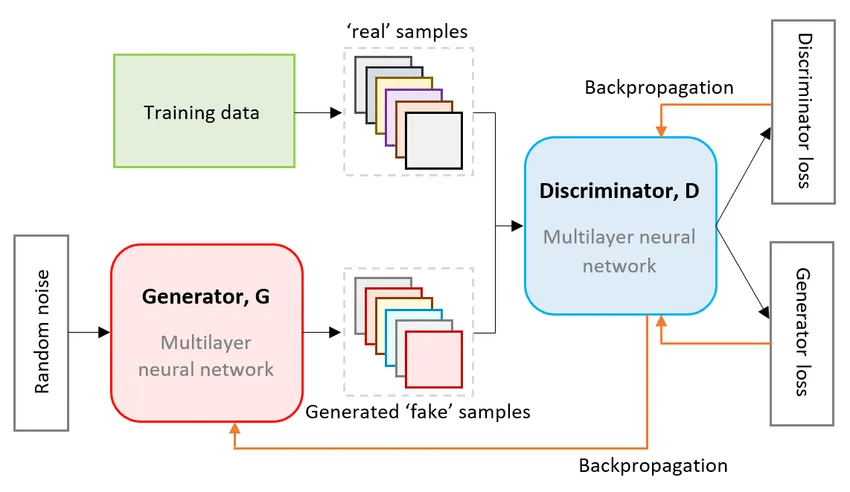

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data. 
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

The GAN loss function: 

# $\min_G$ $\max_D$ $V(D,G)$ = $\mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)]$ + $\mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]$
$\mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)]$: This part measures how well the Discriminator identifies real data. It’s the expected value (average) of $\log D(x)$ over all real samples $x$. The Discriminator wants this to be big, meaning it confidently labels real data as real ($D(x)$ close to 1).

$\mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]$: This measures how well the Discriminator spots fakes. It’s the expected value of $\log (1 - D(G(z)))$ over all fake samples $G(z)$. The Discriminator wants this to be big too, meaning it confidently labels fake data as fake ($D(G(z))$ close to 0).
$\max_D$: The Discriminator tries to maximize this whole expression by getting better at distinguishing real from fake.
$\min_G$: The Generator tries to minimize it by making $G(z)$ so realistic that $D(G(z))$ gets close to 1, which makes $\log (1 - D(G(z)))$ small.
In short, the Discriminator wants to maximize the difference between its confidence in real vs. fake data, while the Generator wants to fool it, collapsing that difference.

# **2. Define the neural networks in pytorch**

In [1]:
# if running on colab, pytorch is already installed.
# if running locally, conda or pip install this in your conda environment:
# conda install pytorch torchvision -c pytorch
# OR
# pip3 install torch torchvision
# I'll be assuming python >=3.6 and torch 1.0.1 which currently are the colab defaults.

In [2]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
2.4.1+cu124


## torch basics

PyTorch is a package that defines vectors, matrices, or in general "tensors". If you know numpy, you will not be surprised by any of these:

In [3]:
a = torch.ones(3,3)
a

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [4]:
b = torch.arange(9).float().view(3,3)
b

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [5]:
(a+b)**2

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

In [6]:
b[:,0]

tensor([0., 3., 6.])

In [7]:
a.zero_() # operations with an underscore modify the Tensor in place.
a

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

## **3. Defining the neural networks**

Let's define a small 2-layer fully connected neural network (so one hidden layer) for the discriminator `D`:

In [37]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_features=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.activation = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.activation(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

And a small 2-layer neural network for the generator `G`. `G` takes a 100-dimensional noise vector and generates an output of the size matching the data.

In [38]:
class Generator(nn.Module):
    def __init__(self, in_features=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.activation = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.activation(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out
    

In [39]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


Note that the dimensions of D input and G output were defined for MNIST data.

## **4. Testing the neural networks (forward pass)**

In [11]:
# A small batch of 3 samples, all zeros.
samples = torch.randn(5, 1, 28, 28) # batch size x channels x width x height
# This is how to do a forward pass (calls the .forward() function under the hood)
D(samples)

tensor([[0.5265],
        [0.5876],
        [0.4927],
        [0.5476],
        [0.5159]], grad_fn=<SigmoidBackward0>)

Things to try:
* What happens if you change the number of samples in a batch?
* What happens if you change the width/height of the input?
* What are the weights of the discriminator? You can get an iterator over them with `.parameters()` and `.named_parameters()`

In [12]:
for name, p in D.named_parameters():
    print(name, p.shape)

fc1.weight torch.Size([128, 784])
fc1.bias torch.Size([128])
fc2.weight torch.Size([1, 128])
fc2.bias torch.Size([1])


We will think of the concatentation of all these discriminator weights in one big vector as $\theta_D$.

Similaryly we call the concatentation of all the generator weights in one big vector as $\theta_G$.

In [13]:
for name, p in G.named_parameters():
    print(name, p.shape)

fc1.weight torch.Size([128, 100])
fc1.bias torch.Size([128])
fc2.weight torch.Size([784, 128])
fc2.bias torch.Size([784])


In [14]:
# A small batch of 2 samples, random noise.
z = torch.randn(2, 100)
# This is how to do a forward pass (calls the .forward() function under the hood)
x_gen = G(z)
x_gen.shape

torch.Size([2, 1, 28, 28])

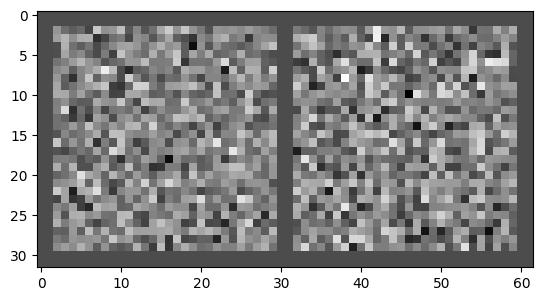

In [15]:
z = torch.randn(2, 100)
show_imgs(G(z))

## **5. Loading the data and computing forward pass**

In [16]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Dataset and DataLoader are abstractions to help us iterate over the data in random order.

Let's look at a sample:

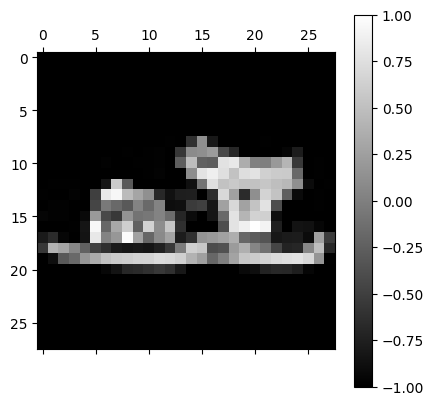

In [40]:
# plot the figure with number of ix=121, you can try to plot other samples
ix=121
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

Feed the image into the discriminator; the output will be the probability the (untrained) discriminator assigns to this sample being real.

In [18]:
# for one image:
Dscore = D(x)
Dscore

tensor([[0.5660]], grad_fn=<SigmoidBackward0>)

In [19]:
# How you can get a batch of images from the dataloader:
xbatch, _ = next(iter(dataloader))# 64 x 1 x 28 x 28: minibatch of 64 samples
#D(xbatch) # 64x1 tensor: 64 predictions of "real" probability
xbatch.shape
# D(xbatch).shape

torch.Size([64, 1, 28, 28])

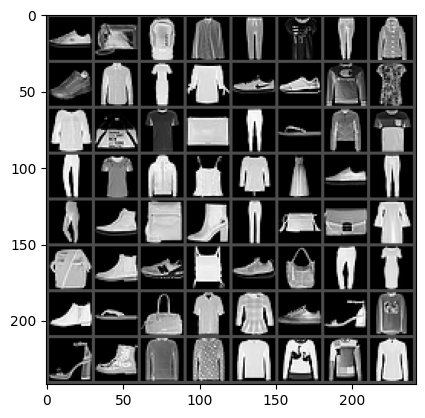

In [20]:
show_imgs(xbatch)

# **6. GANs: The min-max game.**

Indeed this is very close to the optimal $\theta=[3,0]$.

We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. With the intermezzo on optimization we also understand how we optimize neural networks in pytorch.

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.



## **7. GANs: Single training loop demonstration.**

In [41]:
# Remember we have defined the discriminator and generator as:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [42]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

In [43]:
# STEP 1: Discriminator optimization step
x_real, _ = next(iter(dataloader))
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

print(D_x.mean().item(), D_G_z.mean().item())

0.5062137842178345 0.4694927930831909


Some things to think about / try out / investigate:
* what are the mean probabilities for real and fake? print them and see how they change when executing the cell above a couple of times. Does this correspond to your expectation?
* can you confirm how the use of the criterion maps to the objective stated above?
* when calling backward, the derivative of the loss wrt **what** gets computed?
* what does `.detach()` do? Are the Generator parameters' gradients computed?

In [44]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real) # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.46824419498443604


Again run this cell a couple of times. See how the generator increases its Discriminator score?

Some more things to ponder:
* Do the Generator parameters now receive gradients? Why (compared to previous loop)?
* From the definition of BCE loss confirm that this comes down to $-\log D(G(z))$

## **8. Putting it all together: the full training loop**

Modifications to the code:
* add device parameter to take GPU if available
* use [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) (an adaptive learning-rate variation of SGD with momentum)
* some very minimal logging

Device:  cuda
e0.i0/938 last mb D(x)=0.5284 D(G(z))=0.5206
e0.i100/938 last mb D(x)=0.9388 D(G(z))=0.3518
e0.i200/938 last mb D(x)=0.8953 D(G(z))=0.2217
e0.i300/938 last mb D(x)=0.6867 D(G(z))=0.3648
e0.i400/938 last mb D(x)=0.9450 D(G(z))=0.0678
e0.i500/938 last mb D(x)=0.8414 D(G(z))=0.2090
e0.i600/938 last mb D(x)=0.8574 D(G(z))=0.1998
e0.i700/938 last mb D(x)=0.9119 D(G(z))=0.1299
e0.i800/938 last mb D(x)=0.9724 D(G(z))=0.0346
e0.i900/938 last mb D(x)=0.5148 D(G(z))=0.2888
e1.i0/938 last mb D(x)=0.7445 D(G(z))=0.2804
e1.i100/938 last mb D(x)=0.9270 D(G(z))=0.0893
e1.i200/938 last mb D(x)=0.8318 D(G(z))=0.0886
e1.i300/938 last mb D(x)=0.9115 D(G(z))=0.1060
e1.i400/938 last mb D(x)=0.8729 D(G(z))=0.1270
e1.i500/938 last mb D(x)=0.9126 D(G(z))=0.1061
e1.i600/938 last mb D(x)=0.5586 D(G(z))=0.4818
e1.i700/938 last mb D(x)=0.8606 D(G(z))=0.1450
e1.i800/938 last mb D(x)=0.8340 D(G(z))=0.1510
e1.i900/938 last mb D(x)=0.8385 D(G(z))=0.1392
e2.i0/938 last mb D(x)=0.6404 D(G(z))=0.4177
e2.i1

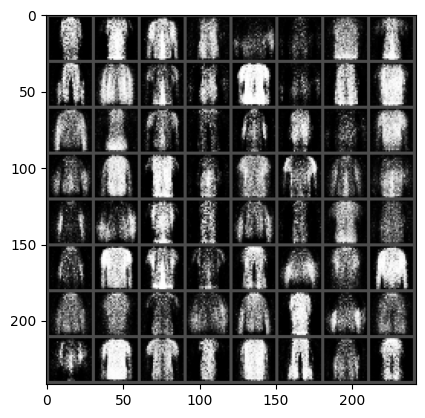

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

for epoch in range(3): # 10 epochs
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = next(iter(dataloader))
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

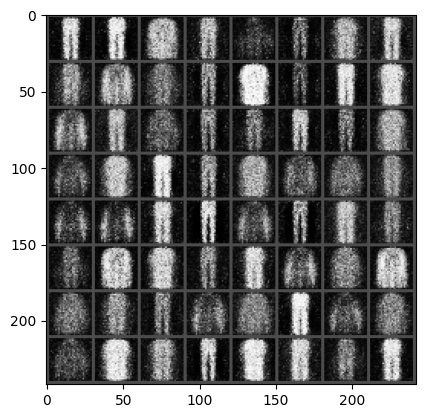

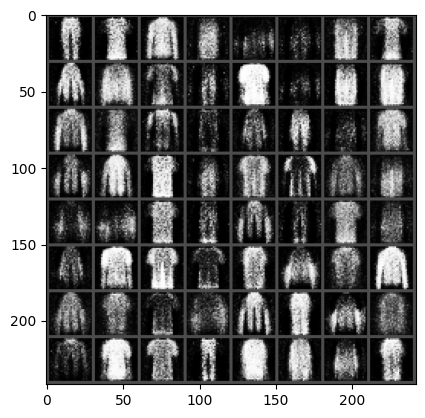

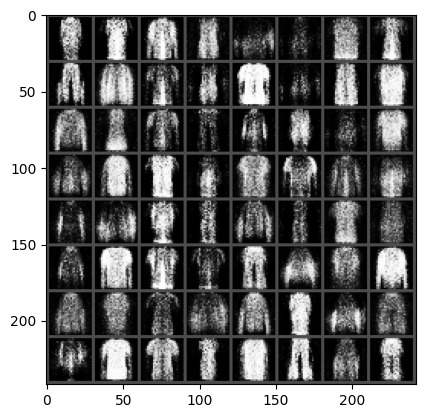

In [46]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)